<h4>Run this cell first.</h4>

In [56]:
# Installs required packages with user prompt if they are not installed
user.input = readline(prompt = "This notebook requires MASS to run. Install MASS Package? (y/n)")
user.input = toupper(user.input) # recast user inpur
if(user.input != "Y" & user.input != "YES") {
        # check user input negation messages
        if(user.input == "N" || user.input == "NO"){
             print("Please note, this notebook will not run without the package.")
             print("Exiting...")
            }
         else{
             print("User input not recognized, please re-run this cell.")
             print("Exiting...")
        }
    } else{ # check confirmation messages
        if(!("MASS" %in% installed.packages())){ 
            print("MASS is not installed. Installing...") 
            install.packages("MASS") 
        } else{
            print("MASS is already installed!")
        } 
    }

# also, try installing matlib if the code doesn't work
# install.packages("matlib")

This notebook requires MASS to run. Install MASS Package? (y/n) y


[1] "MASS is already installed!"


<h4>Import Libraries</h4>

In [25]:
### IMPORT 201 LIBRARIES ###
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(dplyr)
### Import Additional Libraries ###
library(MASS)
### Prerequisite Plot Settings  ###
options(repr.plot.width = 15, repr.plot.height = 7)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [26]:
# Additionally, these should all read true
c("tidyverse", "broom", "repr", "digest", "infer", "gridExtra", "dplyr") %in% installed.packages()

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE

<h2><u>An Investigation into Maximum River Flow</u></h2>

<h3><u>Introduction</u></h3>

<p>            It is aptly noted by Merkuryeva and Kornevs that “floods are the most common natural disasters that often cause significant economic losses, and human and social tragedies” (2013). Furthermore, in assessing potential damage of floods, the flow rate of a river can correspond to severe damage, in particular, the structural damage of road infrastructure (Kreibich et. al, 2009).

<p>            In this Deliverable Project, we will investigate the monthly flow rate recorded by Station 05BB001 on the Bow River, Banff, Alberta, Canada. In particular, we will determine whether or not there is statistically significant evidence to suggest that the maximum flow rate in the Spring months (April, May and June) are greater than the maximum max flow rate in the Summer months (July, August and September). Such an analysis can be potentially used to inform local governments of <u>which times of year</u> potential floods can cause the most structural damage, and set the stage for larger-scale studies.
<p>            We will also utilize this data to determine which statistical model best describes the relation of the fastest-flowing months of the year  (i.e., months with high snow melt: June, July and August) for the Bow River  and the Yearly Average Flow Rate. We’ll consider a constrained dataset and compare the RSS of the functions determined by Cubic Regression, Linear Regression, Polynomial Interpolation and Cubic Spline Interpolation. The best statistical model representing this association could potentially be used by local governments to predict the yearly average flow rate of the Bow River based solely on the maximum measurements across these months. This would be helpful in determining the likelihood that further months of the year have intense or slow-moving speeds.  </p>
<p>            For those interested in the mathematics behind these models, you can find the theory we used in the "Further Reading" section. </p>


<h3><u>Preliminary Results</u></h3>

<h4> Import and Begin Data Cleansing </h4>

In [27]:
# Import CSV From GitHub, originally sourced from https://wateroffice.ec.gc.ca/
df = read.csv("https://raw.githubusercontent.com/cadenhewlett/stat-201-group-33-project/main/monthly_20221102T0350.csv")

# Rename the columns according to original order (which was lost)
colnames(df) = c(
  "ID","PARAM",	"TYPE",	"Year",	"Jan",	"SYM",
  "Feb",	"SYM",	"Mar",	"SYM",	"Apr",	"SYM",
  "May",	"SYM",	"Jun",	"SYM",	"Jul",	"SYM",	"Aug",	
  "SYM",	"Sep",	"SYM",	"Oct",	"SYM",	"Nov",	"SYM",
  "Dec",	"SYM",	"Mean"
)

# Preview the data frame's relevant columns.
head(df[colnames(df)!='SYM' & colnames(df)!='PARAM' & colnames(df)!='TYPE'])

,ID,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Mean
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ID,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Mean
2,05BB001,1909,,,,,,176,164,70.1,44.7,23.6,,,
3,05BB001,1910,,,,,87.5,151,134,78.7,35.6,34.1,,,
4,05BB001,1911,9.82,9.25,8.56,10.4,35.1,177,126,72.7,42.6,19.2,11.7,10.8,44.5
5,05BB001,1912,8.23,7.55,6.34,8.34,42,97,101,99.9,52.3,28.8,16.5,12.2,40.1
6,05BB001,1913,9.1,7.93,7.24,11.7,39.5,159,101,85.7,55.6,28.6,17.1,11.3,44.6


<h4> Construct Data Filter </h4>
<p> Note, while the following method is exhaustive, it could be simplified. <br>
    However, this process was designed to facilitate the extension of the input data to other Stations and/or sources. </p>

In [28]:
# Create Boolean list selector for filtration and cleaning across target columns
springfilter = (  df$Apr != "" & df$Mean != "" &        # remove empty cells
                  df$May != "" & df$Jun != "" & 
                  df$Apr != "Apr" &  df$Jun != "Jun" &  # remove original headers
                  df$May != "May" &  df$Mean != "Mean"& 
                  df$TYPE != "8" )                      # standardize types

# Apply this same process to the Summer Months
summerfilter = (  df$Jul != "" & df$Mean != "" & 
                  df$Sep != "" & df$Aug != "" & 
                  df$Sep != "Sep" &  df$Aug != "Aug" & 
                  df$Jul != "Jul" &  df$Mean != "Mean"& 
                  df$TYPE != "8" )

# The complete filter is then the union of these two boolean sets
completeFilter = springfilter & summerfilter

# In this table, FALSE indicates the number of elements that we will filter out.
print(table(completeFilter))

completeFilter
FALSE  TRUE 
   13   111 


<h4> Apply Filter to the Data Frame </h4>

In [29]:
# Here we subset the different columns of the original dataframe
# Accoriding to the filter we constructed in the previous cell.

# Spring Data : April, May and June
apr_filtered =  as.numeric(df$Apr[completeFilter])
may_filtered =  as.numeric(df$May[completeFilter])
jun_filtered =  as.numeric(df$Jun[completeFilter])
# Summer Data : July, August and September
jul_filtered =  as.numeric(df$Jul[completeFilter])
aug_filtered =  as.numeric(df$Aug[completeFilter])
sep_filtered =  as.numeric(df$Sep[completeFilter])

# Create new sub-dataframes with relevant columns
summerDF = data.frame(jul_filtered, aug_filtered, sep_filtered)
springDF = data.frame(apr_filtered, may_filtered, jun_filtered)

# head(summerDF) # a preview of these data is not very relevant


<h4>Define the Row Maxes Function </h4>

In [30]:
# Here we define our locally referenced rowMaxes functon.

# @param i : the row of interest 
# @param threeDF: a dataframe with three numeric columns
# @return  :  the maximum across the dataframe's columns for the row

rowMax = function(i, threeDF){ 
  v = c( threeDF[i, 1], # get each month
         threeDF[i, 2],
         threeDF[i, 3])
  max(as.numeric(v))} # return the max of the three

# @example: 
example = (data.frame(col1 = c(1, 2), col2 = c(3, 5), col3 = c(-1, 5))) #example DF
# prints the example dataframe with the function applied to both rows
head(example %>% mutate(row_max = c(rowMax(1, example), rowMax(2, example))))


,col1,col2,col3,row_max
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,3,-1,3
2,2,5,5,5


<h4>Apply the Function to the Data Frames </h4>
<p> This will give us the dataset for our investigation. </p>

In [31]:

# Define a new column: result of the rowMax function applied to the Spring DF
springDF[, "max"] <- sapply(1:nrow(springDF), rowMax, threeDF = springDF)
# Define a new column: result of the rowMax function applied to Summer DF
summerDF[, "max"] <- sapply(1:nrow(summerDF), rowMax, threeDF = summerDF)

# Creates the dataset with each of these Maximums, as well as their difference.
maximumDF = tibble(spring = springDF$max, summer = summerDF$max, diff = spring - summer)
# This is now the dataset we'll use for our Hypothesis test and CI 
head(maximumDF)

spring,summer,diff
<dbl>,<dbl>,<dbl>
177.0,126,51.0
97.0,101,-4.0
159.0,101,58.0
139.0,138,1.0
91.6,124,-32.4
139.0,153,-14.0


<h4> Conduct a Hypothesis test for Difference of Means </h4>
<p> Let $\mu_{\text{sp}}$ be the mean maximum flow rate of the Bow River across the Spring Months, in $m^3 / s$ <br>
    Let $\mu_{\text{sm}}$ be the mean maximum flow rate of the Bow River across the Summer Months, in $m^3 / s$ <br>
    We will test the following hypotheses at $\alpha = 0.05$: <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $H_0: \mu_{\text{sp}} = \mu_{\text{sm}}$ <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $H_A: \mu_{\text{sp}} > \mu_{\text{sm}}$ <br>
    We will use the fact that: <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\frac{\bar{D}}{S_D  / \sqrt{n}} \sim t_{n-1}$,   using the test statistic   $\;t = \bar{d} \div {\frac{s_d}{\sqrt{n}}}$

In [32]:
# By method of asymptotics, we know...

# sample mean of differences
d_bar = mean(maximumDF$diff)
# sample size
n = nrow(maximumDF)
# sample standard error
se = (sd(maximumDF$diff) / sqrt(n)) #se(d) = sd / root n
# define the test statistic as explained above
test_stat = d_bar / se 
# then find the p-value as p(t > test_stat)
p_value = pt(test_stat, df = n - 1, lower.tail = FALSE)
# store our results in a tibble
results = tibble(estimate = d_bar, se, test_stat, p_value)

results

estimate,se,test_stat,p_value
<dbl>,<dbl>,<dbl>,<dbl>
21.23514,3.049097,6.964401,1.266249e-10


From these results, we reject the Null Hypothesis at $\alpha = 0.05$. <br>There is statistically significant evidence to suggest that mean maximum flow rate of the Bow River across the Spring Months of Station 05BB001 on the Bow River is greater than the mean maximum flow rate of the Bow River across the Summer Months. the Indeed, the observed $p$ is quite low, so we could reject it at a smaller alpha, too.

<h4> Bootstrap Confidence Interval for the Mean of the Difference Column </h4>

boot_samp_dist_mean,boot_samp_dist_sd,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
21.21431,2.852159,15.50336,26.32457


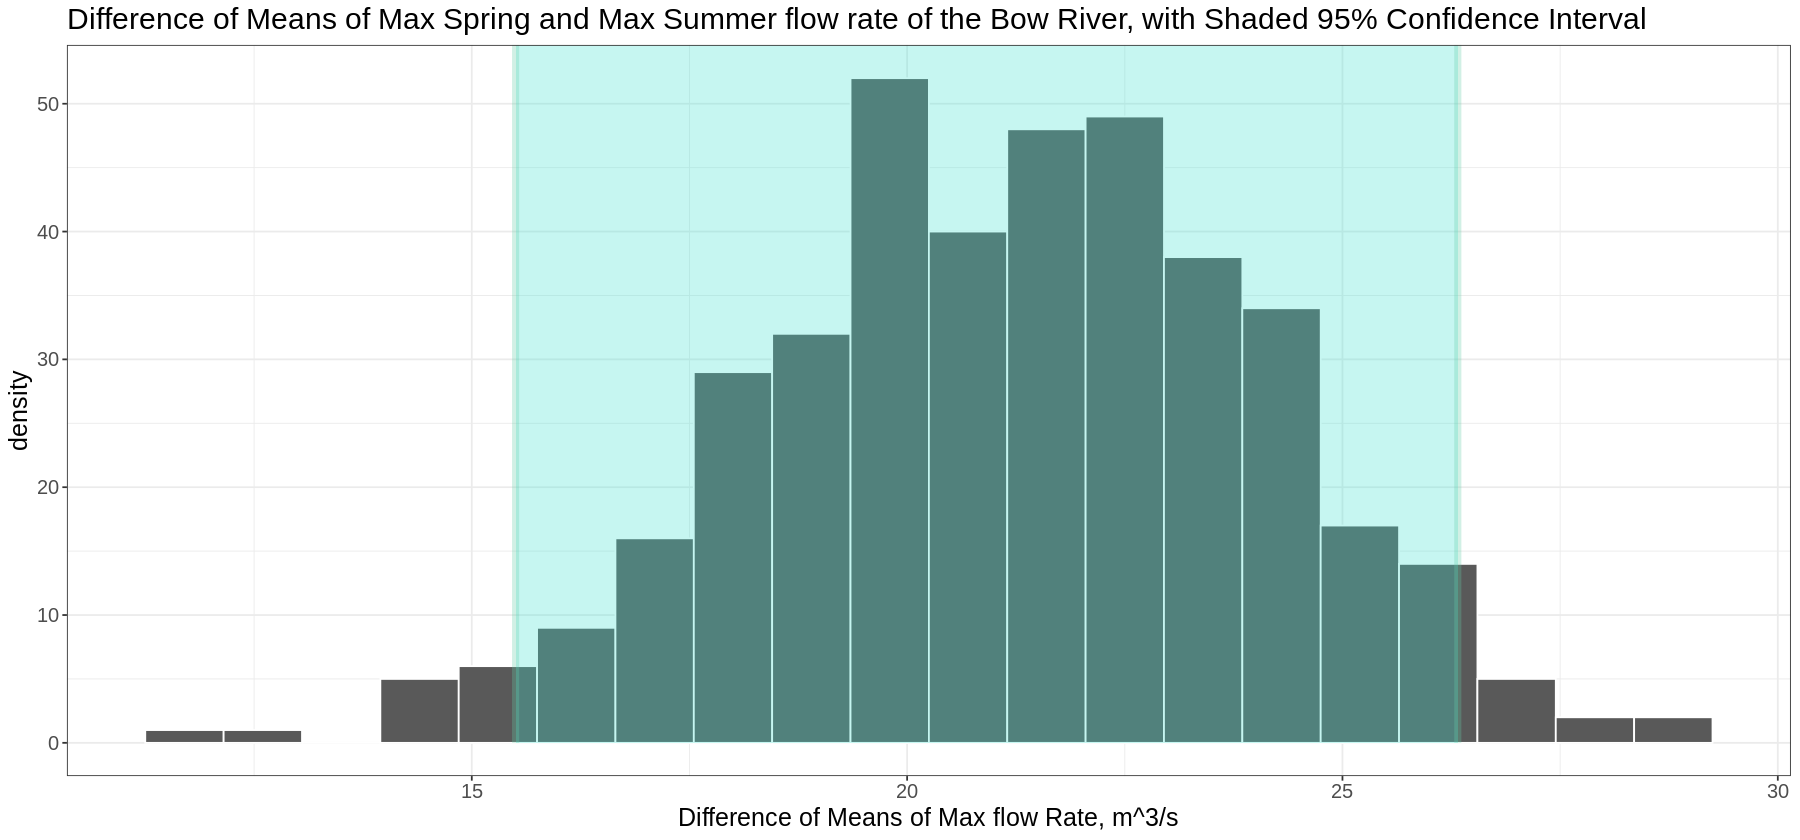

In [33]:
# Bootstrap + Confidence Interval for Difference of Means
set.seed(19690716) # set seed to 1969-07-16 launch date of Apollo 11
         
bootstrap_diff_means = tibble(dval = maximumDF$diff) %>% 
                          rep_sample_n(size = n, reps = 400, replace = TRUE) %>% 
                          group_by(replicate) %>% summarise(bootstrap_mean = mean(dval))

bootstrap_diff_means_ci = bootstrap_diff_means %>% get_ci(type = "percentile", level = 0.95)

bootstrap_results = tibble(boot_samp_dist_mean = mean(bootstrap_diff_means$bootstrap_mean),
                           boot_samp_dist_sd   = sd(bootstrap_diff_means$bootstrap_mean),
                           bootstrap_diff_means_ci)
# plot the confidence interval
bootstrap_diff_means %>% ggplot(aes(x = bootstrap_mean)) + geom_histogram(binwidth = 0.9, col = 'white') + 
                           theme_bw() + shade_confidence_interval(bootstrap_diff_means_ci, alpha = 0.3) +
                           ggtitle("Difference of Means of Max Spring and Max Summer flow rate of the Bow River, with Shaded 95% Confidence Interval") + 
                           labs(x = "Difference of Means of Max flow Rate, m^3/s", y = "density")  + theme(text = element_text(size = 15))

bootstrap_results

<h5>Interpretation </h5>
The 95% bootstrap confidence interval, rounded to 2 decimal places, was found to be $CI(0.95) = (15.50, 26.32)$ <br>
The spread and shape of this bootstrap distribution most closely resembles the corresponding sampling distribution. We can say with 95% confidence that the true mean of the sampling distribution of the difference of Max Spring flow rate and Max Summer flow rate of Station 05BB001 on the Bow River is captured by the confidence interval. To that end, if we repeated the same process used to calculate the 95% confidence interval a large number of times, in 95 out of 100 of the intervals calculated, the true mean of the of the sampling distribution of the difference of Max Spring flow rate of and Max Summer flow rate will fall between the lower bound of appx. $CI_\text{lower} = 15.50$ and the upper bound of appx. $CI_\text{upper} = 26.32$

<h4> Part 2: An Examination into Approximating Functions </h4>
<p> We noticed that June, July and August appeared to be the most influential months. <br>
    While modelling the relationship of the maximum across these months and the yearly average flow rate, we'll be conducting an analysis on four different approximation methods for small, well-conditioned samples.<br>
    We'll begin by constructing a data filter for June, July, August and the Yearly Mean flow rate.


In [34]:
# Create Boolean list selector for filtration and cleaning across target columns

# Create another cross-column filter, like we did before.
datafilter = (   df$Jul != "" & df$Mean != "" & 
                 df$Jun != "" & df$Aug != "" & 
                 df$Jun != "Jun" &  df$Aug != "Aug" & 
                 df$Jul != "Jul" &  df$Mean != "Mean"& 
                 df$TYPE != "8" )

# Filter the original dataframe according to this list
jun_filtered  =  df$Jun[datafilter]
jul_filtered  =  df$Jul[datafilter]
aug_filtered  =  df$Aug[datafilter]
mean_filtered =  df$Mean[datafilter] # with the addition of the mean col.

# Create new dataframe with relevant columns
computeDF = data.frame(jun_filtered, jul_filtered, aug_filtered, mean_filtered)


# Define a new column: result of the max function applied to compute df
computeDF[, "max"] <- sapply(1:nrow(computeDF), rowMax, threeDF = computeDF)

# Reast relevant columns to numeric
computeDF$max = as.numeric(computeDF$max)
computeDF$mean_filtered = (as.numeric(computeDF$mean_filtered))

<h4>Well-Conditioned Sample from the Data</h4>
<p> These data will yield a high likelihood of well-defined functions, however it is not an unbiased sample, thus conclusions are not as strong as they could be.<br>
    Please refer to the in-line documentation of
    this section to better understand the sampling methodology.

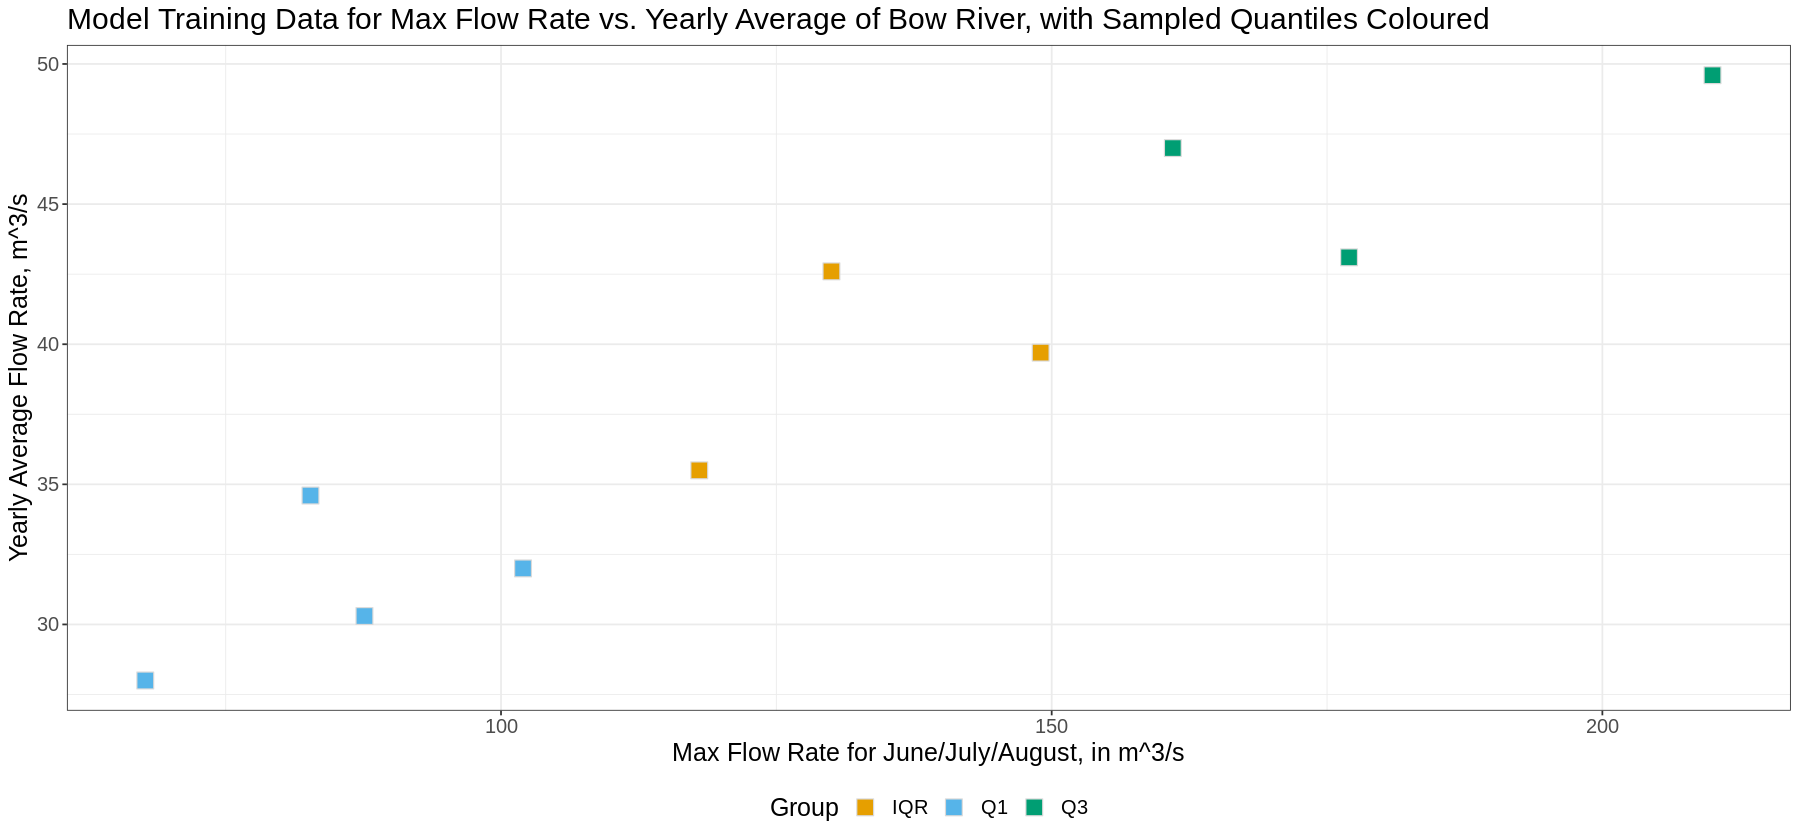

In [35]:

# Note: This particular seed shows all of the methods at their "best"
# In general, polynomial interpolation had a very high RSS, and, as a result, ruined the plot. The results for CSP, LReg and CReg are 
# Characteristic of the repeated tests we conducted on different seeds.
set.seed(202200)

## METHOD: How do we ensure that the functions we create are well defined? 
## 1.) Sample from the 3 different groups of the population, divided by the 5-Number-Summary.
## 2.) Append the Minimum and Maximum of the population, to provide bounds to help precision of interpolating functions.
## 3.) Filtering out sample results that would cause our functions to fail the 'vertical line test.'   

# Determine 1st and 3rd Quantiles of the Max Column
q1 = quantile(computeDF$max, 0.25)
q3 = quantile(computeDF$max, 0.75)

# Split the data into the 5-Number-Summary as mentioned earlier
minVal = computeDF[computeDF$max == min(computeDF$max), ]
lower  = computeDF[computeDF$max <= q1 & computeDF$max != min(computeDF$max), ]
middle = computeDF[computeDF$max >  q1 & computeDF$max < q3, ]
upper  = computeDF[computeDF$max >= q3 & computeDF$max != max(computeDF$max), ]
maxVal = computeDF[computeDF$max == max(computeDF$max), ]

# Then Sample these Sections of the data
trainDF = rbind(minVal,
                lower %>%  rep_sample_n(size = 6) %>% ungroup() %>% dplyr::select(-replicate),
                middle %>% rep_sample_n(size = 8) %>% ungroup() %>% dplyr::select(-replicate),
                upper %>%  rep_sample_n(size = 6) %>% ungroup() %>% dplyr::select(-replicate),
                maxVal)

# Ensure that the data do not yield linearly dependent tuples
trainDF = trainDF[!duplicated(round(0.5*trainDF$mean_filtered)),]
trainDF = trainDF[!duplicated(round(0.5*trainDF$max)),]

# multiply x by a factor of 0.1 to reduce matrix magnitude (next section)
train_x = 0.1*trainDF$max
train_y = 0.5*trainDF$mean_filtered

# Visualize the Sampling Methodology : TODO Make this plot pretty
trainDF %>% mutate(Group = as.factor(ifelse(max <= q1, "Q1", ifelse(max >= q3, "Q3", "IQR")))) %>%
  ggplot(aes(x = max, y = mean_filtered, fill = Group))+
  geom_point(shape = 22, color = "grey85", size = 5) + 
  scale_fill_manual(values = c("#E69F00", "#56B4E9", "#009E73"))  +
  ggtitle("Model Training Data for Max Flow Rate vs. Yearly Average of Bow River, with Sampled Quantiles Coloured") + 
  labs(x = "Max Flow Rate for June/July/August, in m^3/s", y = "Yearly Average Flow Rate, m^3/s") + 
  theme_bw() + theme(text = element_text(size = 15), legend.position = "bottom")

<h4> Determine Polynomial Interpolation Function, from Training Data </h4>
<p>  <i>Note:</i> For a detailed explanation on this medology, please refer to the <i>Further Reading</i> section at the end of this document.

In [48]:

# Add endpoints and fewer interior points to reduce the chance an ill-conditioned matrix 
x1 =  c(train_x[1], train_x[seq(2, length(train_x)-1, 3)], train_x[length(train_x)] ) 
y1 =  c(train_y[1], train_y[seq(2, length(train_y)-1, 3)], train_y[length(train_y)] )

# Define matrix dimension
n <- length(x1) 

# Compute & Construct the Vandermonde Matrix 
vander <- matrix(outer(x1, seq(0, n-1), `^`), nrow = n, ncol = n)

# Solve the system c = (A^-1)y for Polynomial Coefficients
coefs = (solve(vander) %*% y1) 

# Calculates the Distinct Polynomial Interpolation at x
coeftoCurve = function(x_val){
    # Reduces the list of c0 + (xi)c1 + (xi^2)(c2) ... (xi)^d (cd) by summation
     Reduce(`+`, lapply (1:n, function(i) x_val^(i-1) * coefs[i]))
}

# Creates plot with sample data and corresponding function curve 
plt_ply = tibble(x1, y1) %>% ggplot(aes(x1, y1)) + 
                           geom_point() +  # plot the sample points
                           geom_function(fun = coeftoCurve, color = "#c25993", lwd = 0.7) +  # plots the polynomial interpolation
                           ggtitle(paste("Polynomial Interpolation of Degree ", n))  + 
                           labs(y = "Scaled Yearly Average, (m^3/s)", x = "Scaled Maximums, (m^3/s)") +
                           theme(axis.text =  element_text(size = 12),
                                plot.title = element_text(size = 16), 
                                axis.title = element_text(size = 10))
       

<h4> Determine Cubic Regression Function, from Training Data </h4>
<p>  <i>Note:</i> For a detailed explanation on this medology, please refer to the <i>Further Reading</i> section at the end of this document.

In [50]:

# Locally re-define training data for conciseness of code
x =  train_x
y =  train_y

# Build Matrix from system of Minimization Equations
A = matrix( c( sum(x^6), sum(x^5), sum(x^4), sum(x^3), 
               sum(x^5), sum(x^4), sum(x^3), sum(x^2),
               sum(x^4), sum(x^3), sum(x^2), sum(x^1),
               sum(x^3), sum(x^2), sum(x^1), sum(x^0)), 
            nrow = 4, ncol = 4)

# Build "Results" Vector, y, which is 4x1.
y_vec = matrix( c( sum(x^3 * y), 
                   sum(x^2 * y), 
                   sum(x * y), 
                   sum(y)), # equivalent to x^0*y
            nrow = 4, ncol = 1)

# Solve the matrix equation c = (A^-1)y to find coefficients a,b,c and d
rcoefs = solve(A) %*% y_vec

# This function determines the values of the regression line at input x
cubetoCurve <- function(x_val){
    # this is equivalent to ax^3 + bx^2 + cx + d
    (rcoefs[1]*(x_val^3) + rcoefs[2]*(x_val^2) + rcoefs[3]*(x_val) + rcoefs[4])
}

# Creates plot with sample data and the corresponding function curve 
plt_reg = tibble(x, y) %>% ggplot(aes(x, y)) + 
                         geom_point() + # plot the sample points
                         geom_function(fun = cubetoCurve, color = "#0090e0", lwd = 0.7) + # plot the cubic regression
                         ggtitle("Cubic Regression") + 
                         labs(y = "Scaled Yearly Average, (m^3/s)", x = "Scaled Maximums, (m^3/s)") +
                         theme(axis.text =  element_text(size = 12),
                                plot.title = element_text(size = 16), 
                                axis.title = element_text(size = 10))

<h4> Determine Cubic Spline Interpolation Funtion, from Training Data </h4>
<p>  <i>Note:</i> For a detailed explanation on this medology, please refer to the <i>Further Reading</i> section at the end of this document.

In [52]:

# Note: This is an imported version of Cubic Spline Interpolation determination
#       Since non-natural Cubic Spline Interpolation is computationally-intensive
splinetoCurve = splinefun(x = x, y = y, "natural") # the distinct value of the corresponding spline at x

plt_csp = tibble(x,  y) %>% ggplot(aes(x, y)) + 
                          geom_point() + # plot sample points
                          geom_function(fun = splinetoCurve, color = "#D55E00", lwd = 0.7) + # plot cubic spline through the points
                          ggtitle("Cubic Spline Interpolation") + 
                          labs(y = "Scaled Yearly Average, (m^3/s)", x = "Scaled Maximums, (m^3/s)") +
                          theme(axis.text =  element_text(size = 12),
                                plot.title = element_text(size = 16), 
                                axis.title = element_text(size = 10))

<h4> Determine Linear Regression Funtion, from Training Data </h4>
<p>  <i>Note:</i> For a brief explanation on this medology, please refer to the <i>Further Reading</i> section at the end of this document.

In [54]:

# determine slope estimate from sample data
beta_hat = sum((x - mean(x))*(y - mean(y))) / sum((x - mean(x))^2)
# determine intercept estimate from sample data
alpha_hat = mean(y) - beta_hat*mean(x)

# Determines the values of the regression line at input x
lineartoCurve <- function(x_val){
    beta_hat*(x_val) + alpha_hat}

plt_lin = tibble(x, y) %>% ggplot(aes(x, y)) + 
                          geom_point() +  # plot sample points
                          geom_function(fun = lineartoCurve, color = "#19bf9b", lwd = 0.7) + # plot reg. line
                          ggtitle("Linear Regression") + 
                          labs(y = "Scaled Yearly Average, (m^3/s)", x = "Scaled Maximums, (m^3/s)") + 
                          theme(axis.text =  element_text(size = 12),
                                plot.title = element_text(size = 16), 
                                axis.title = element_text(size = 10))


<h4> Plot Each Function with Training Data </h4

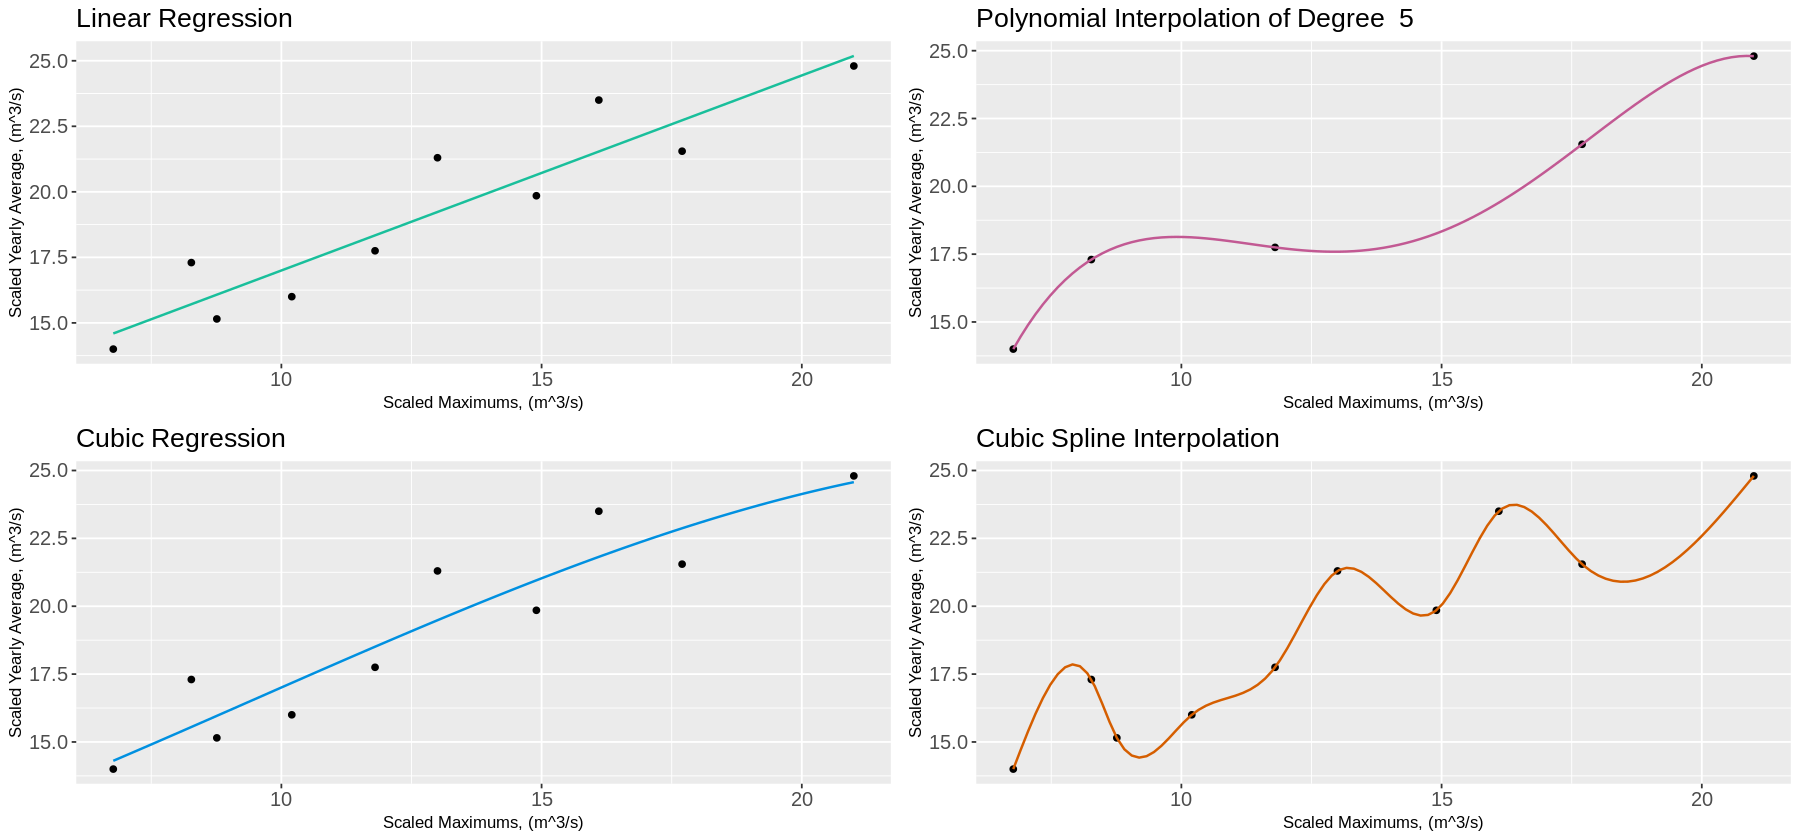

In [40]:
# arrange all four approximating functions side-by-side
grid.arrange(plt_lin, plt_ply, plt_reg, plt_csp,  ncol = 2, nrow = 2) 

<h4>Compare All Approximations with Original Data</h4>

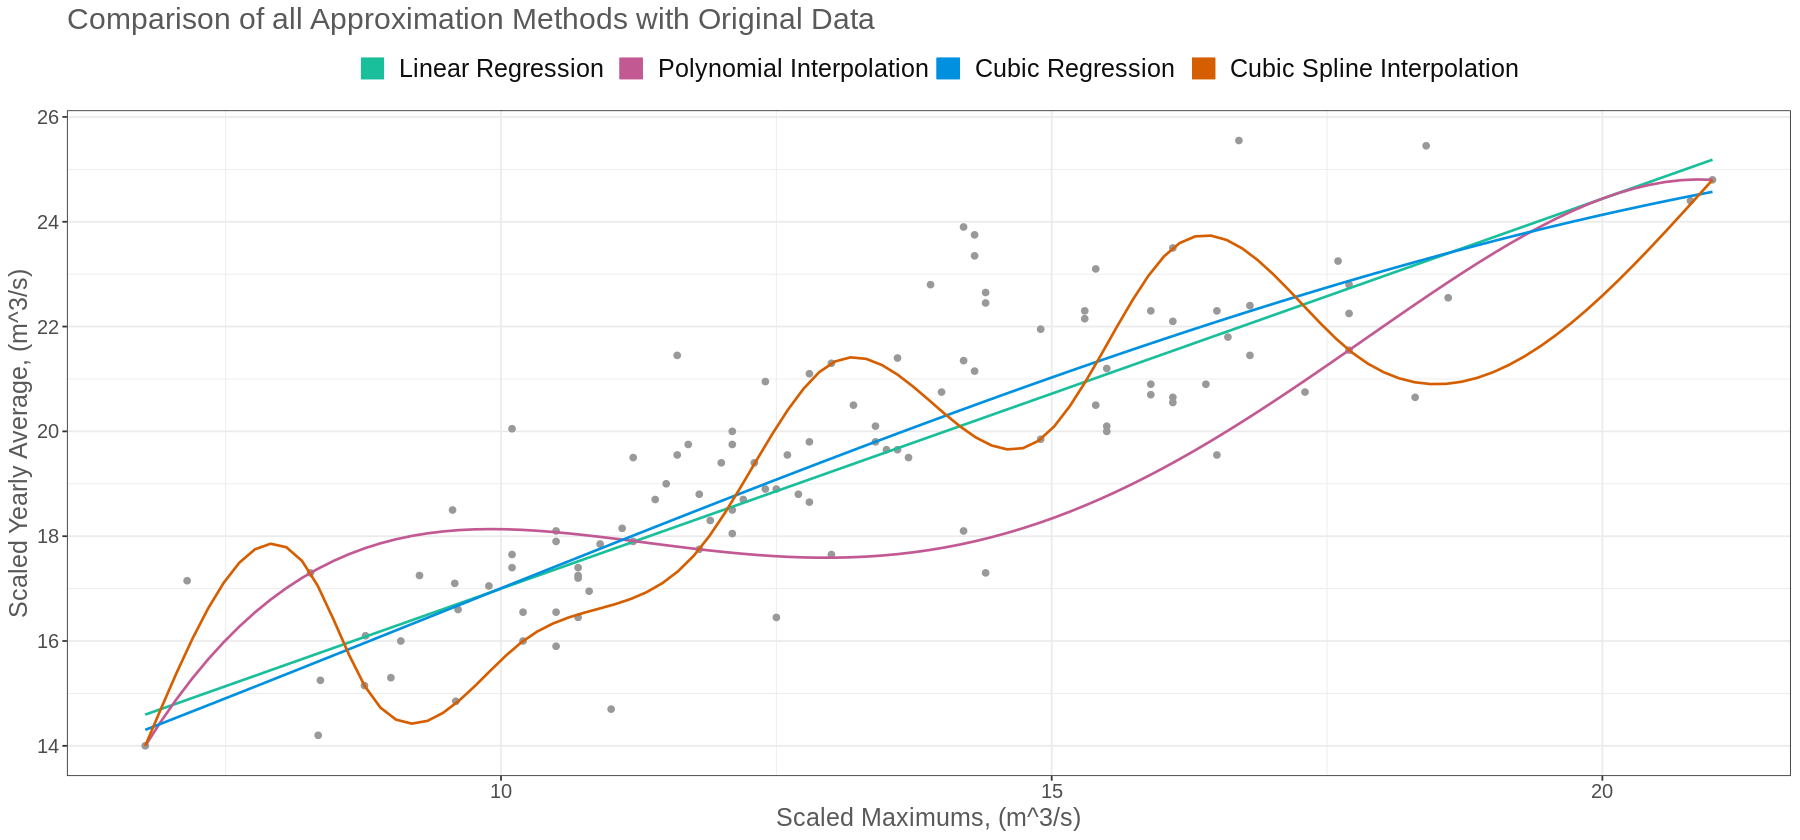

In [41]:
##       Plot all models on the same axis      ##
## With data frame data instead of sample data ##

# Reshape dataframe columns according to computational simplifications
modified_fn_input =  0.10*as.numeric(computeDF$max)
modified_df_actual = 0.5*(as.numeric(computeDF$mean_filtered))

# create different range dataframes so that functions can be factors, helps for legends + colours
plot.range1 <- data.frame(x = modified_fn_input, Functions = factor(1))
plot.range2 <- data.frame(x = modified_fn_input, Functions = factor(2))
plot.range3 <- data.frame(x = modified_fn_input, Functions = factor(3))
plot.range4 <- data.frame(x = modified_fn_input, Functions = factor(4))

ggplot(NULL, aes(x=x, colour=Functions)) +
    geom_point(inherit.aes = FALSE, aes(x = modified_fn_input, y = modified_df_actual), color = "grey60") +
    stat_function(data = plot.range1, fun = lineartoCurve, lwd = 0.75) +
    stat_function(data = plot.range2, fun = coeftoCurve, lwd = 0.75) +
    stat_function(data = plot.range3, fun = cubetoCurve, lwd = 0.75) +
    stat_function(data = plot.range4, fun = splinetoCurve, lwd = 0.75) +
    scale_colour_manual(values = c("#19bf9b", "#c25993", "#0090e0", "#D55E00"), 
                        labels = c("Linear Regression ", "Polynomial Interpolation " , 
                                   "Cubic Regression ", "Cubic Spline Interpolation ")) +
    ggtitle("Comparison of all Approximation Methods with Original Data") + 
    labs(y = "Scaled Yearly Average, (m^3/s)", x = "Scaled Maximums, (m^3/s)") + theme_bw() + 
    # add theme
    theme(text = element_text(size = 15, color = "grey35"), # make text lighter 
          legend.text = element_text(size = 15, color = "grey5"), # legend darker
          legend.position = "top",  # relocate legend
          legend.title = element_blank()) +  # remove the title
    # add manual fill boxes for legend (easier reading)
    guides(colour = guide_legend(override.aes = list(size = 6)))

<h4>Compute the RSS and Mean of Residuals for Each Model:</h4>
<p> The RSS is found using $RSS = \sum_{i = 1}^n (y_i - \hat{y}_i)^2 $ where $\hat{y}_i = f(x_i)$ is the predicted $y_i$ at $x_i$, and $(x_i, y_i)$ is the $i$-th point from the original data.

In [42]:

# Compute the Residuals of each model
# Where the residual is "Predicted Y - Actual Y"
resid_csp = (splinetoCurve(modified_fn_input) - modified_df_actual)
resid_reg = (cubetoCurve(modified_fn_input) - modified_df_actual)
resid_ply = (coeftoCurve(modified_fn_input) - modified_df_actual)
resid_lin = (lineartoCurve(modified_fn_input) - modified_df_actual)

# Summarize our findings in a Data Frame, and make it look like a table
pt2_Results = data.frame(
                 # by definition RSS is the sum of the squared residuals
                RSS = c(sum(resid_csp^2), 
                        sum(resid_reg^2), 
                        sum(resid_ply^2), 
                        sum(resid_lin^2)),
                  # also find the avg. residual for further comparisons
                Mean_Residual = c(
                        mean(resid_csp),  
                        mean(resid_reg), 
                        mean(resid_ply), 
                        mean(resid_lin)))
# Set Row Names to Improve Clarity
rownames(pt2_Results) = c("Cubic Spline","Cubic Regression","Polynomial Interp.","Linear Regression")
pt2_Results


,RSS,Mean_Residual
,<dbl>,<dbl>
Cubic Spline,379.8228,-0.2551194
Cubic Regression,213.2570,-0.1258203
Polynomial Interp.,610.9819,-1.0970445
Linear Regression,225.3987,-0.2720949


<h4><u>Preliminary Findings</u></h4>
<p> The two regression models (Cubic and Linear) outperformed both the Interpolation methods in the sample derived from this particular seed for the three examined months from Station 05BB001 on the Bow River, with the Cubic Regression having a slightly lower RSS than the Linear model. <br>
    We know this is the case since the Residual Sum of Squares as well as the Average Residual is lower for these models than their interpolation counterparts. 

<h4><u>Methods: Plan</u></h4>
<b> Reliability of this Work </b>
<p> This report can be considered trustworthy because it strictly follows the accepted standards of statistical procedure and methodology. For example, our hypothesis test was conducted at the standard $\alpha = 0.05$ and thus our results are not subject to p-hacking. 
    Furthermore, our conclusions drawn from the inferences (hypothesis test and CI) as well as our observational analytics are carefully worded, explicitly stating the (relatively minimal) context to which our findings can be applied. In other words, we aren’t over-generalizing our findings. </p>
<b> Shortcomings and Future Development </b>
<p> The plots and estimates in the first section are generally insufficient, because they are not entirely generalizable. In our setting, the potential client who would take action on our findings would likely be the provincial government of the municipality of Banff. This stakeholder would probably be hesitant to incorporate large-scale changes in infrastructure or disaster relief planning based solely on the findings of one station on the Bow River, which spans roughly 587km. We could shorten this gap by investigating the readings of other stations along the Bow River. A logical future development would be to gather data from other stations and see if the both the hypothesis test and the bootstrap confidence interval for difference of means, created following the same procedure as done here, would yield the same or similar results. <br> 
    The second method is not currently sufficient, either. This is largely due to the fact that the methodology was conducted on a single imperfect random sample of the data. Future development in this method will involve us to replicating the procedure on multiple samples, thus allowing us to create a sampling distribution for RSS Scores of each model. With these sampling distributions, we could draw much stronger conclusions on which function best describes the relationship between the fastest-flowing months of the year and the yearly average flow rate. Another potential improvement would be to develop a sampling methodology more in-line with true random sampling. </p>
 <b> Future Predictions and Expansions to this Work </b>  
 <ol> <li>In our final report, we expect to find similar results to those shown in our preliminary findings: specifically that Spring Max is larger than Summer Max, and that the relationship between Maximum Flow Rate months and Yearly Average is best suited to a Linear or Cubic Model. However, such studies will be more refined and applied to a larger set of data with stronger statistical conclusions. </li>
    <li>As mentioned in the introduction, such findings could help local governments predict the time of year when potential flood damage is most severe (Part 1), as well as what the rest of the year could look like, based simply on the results of the highest-rate of river flow (Part 2).</li>
    <li>This could lead to further studies in the field of hydrology; specifically, predictive models on flood risk based on the best-fitting model for maximum flow rate vs. yearly average. Furthermore, an expansion of this study into other rivers could inform further study into infrastructure development based on potential flood risk and the variable flow rates of rivers throughout the year. 
 </ol>

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.1//EN" "http://www.w3.org/TR/xhtml11/DTD/xhtml11.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en">
<head>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8"/>
    <h4><b>Sources and Related Work</b></h4>
</head>
<body>
<div class="csl-bib-body" style="line-height: 2; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">Merkuryeva, G. V., &amp; Kornevs, M. (2013). Water Flow Forecasting and River Simulation for Flood Risk Analysis. <i>Information Technology and Management Science</i>, <i>16</i>(1). <a href="https://doi.org/10.2478/itms-2013-0006">https://doi.org/10.2478/itms-2013-0006</a></div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.2478%2Fitms-2013-0006&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Water%20Flow%20Forecasting%20and%20River%20Simulation%20for%20Flood%20Risk%20Analysis&amp;rft.jtitle=Information%20Technology%20and%20Management%20Science&amp;rft.volume=16&amp;rft.issue=1&amp;rft.aufirst=Galina%20V.&amp;rft.aulast=Merkuryeva&amp;rft.au=Galina%20V.%20Merkuryeva&amp;rft.au=Maksims%20Kornevs&amp;rft.date=2013-01-01&amp;rft.issn=2255-9094%2C%202255-9086"></span>
</div></body>
    </head>
<body>
<div class="csl-bib-body" style="line-height: 2; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">Kreibich, H., Piroth, K., Seifert, I., Maiwald, H., Kunert, U., Schwarz, J., Merz, B., &amp; Thieken, A. H. (2009). Is flow velocity a significant parameter in flood damage modelling? <i>Natural Hazards and Earth System Sciences</i>, <i>9</i>(5), 1679–1692. <a href="https://doi.org/10.5194/nhess-9-1679-2009">https://doi.org/10.5194/nhess-9-1679-2009</a></div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.5194%2Fnhess-9-1679-2009&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Is%20flow%20velocity%20a%20significant%20parameter%20in%20flood%20damage%20modelling%3F&amp;rft.jtitle=Natural%20Hazards%20and%20Earth%20System%20Sciences&amp;rft.stitle=Nat.%20Hazards%20Earth%20Syst.%20Sci.&amp;rft.volume=9&amp;rft.issue=5&amp;rft.aufirst=H.&amp;rft.aulast=Kreibich&amp;rft.au=H.%20Kreibich&amp;rft.au=K.%20Piroth&amp;rft.au=I.%20Seifert&amp;rft.au=H.%20Maiwald&amp;rft.au=U.%20Kunert&amp;rft.au=J.%20Schwarz&amp;rft.au=B.%20Merz&amp;rft.au=A.%20H.%20Thieken&amp;rft.date=2009-10-14&amp;rft.pages=1679-1692&amp;rft.spage=1679&amp;rft.epage=1692&amp;rft.issn=1684-9981&amp;rft.language=en"></span>
</div></body>
</html>


<i>Original data sourced from</i> <a href="https://wateroffice.ec.gc.ca/">https://wateroffice.ec.gc.ca/</a>, <i>Government of Canda, wherein the tables are considered public information and may be distributed or copied. Please visit</i>  <a href=" https://www.canada.ca/en/transparency/terms.html"> https://www.canada.ca/en/transparency/terms.html</a> <i>for more information on reproducibility.</i>

<h4><b><u>Further Reading</u></b></h4>

<b> Determining a Linear Regression Model </b>
<p> The most common way to determine $\hat{\beta}$ and the intercept term $\hat{\alpha}$ for the regression model $y = \hat{\alpha} + \hat{\beta} x $ is by directly using the following two equations and the sample data: <br>
     $$ \begin{split}
       \hat{\beta} = \frac{\sum_{i=1}^n(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n(x_i - \bar{x})^2} 
       \hspace{10mm}
       \hat{\alpha} = \bar{y} - \hat{\beta}{\bar{x}}
       \end{split}$$

<b>Determining a Cubic Regression Model</b><br>
It is found by computing the partial derviatives of the RSS function, $$RSS = \sum_{i = 1}^n (y_i - (ax_i^3 + bx_i^2 + cx_i + d))^2$$ With respect to the unkowns: $a$, $b$, $c$ and $d$. Then, we set the partial derivatives to zero (minimize) and solve the system of four equations. <br><br>
When you simplify the equations collected from the partial derivatives, you can derive the Matrix Equation $A\vec{c} = \vec{x}$, where: <br>
$$ 
\begin{split}
 A = 
\begin{bmatrix}
\sum x_i^6 & \sum x_i^5 & \sum x_i^4 & \sum x_i^3 \\
\sum x_i^5 & \sum x_i^4 & \sum x_i^3 & \sum x_i^2 \\ 
\sum x_i^4 & \sum x_i^3 & \sum x_i^2 & \sum x_i \\ 
\sum x_i^3 & \sum x_i^2 & \sum x_i &  n  
\end{bmatrix} 
\hspace{10mm}
\boldsymbol{\vec{c}} = \begin{bmatrix} a \\ b \\ c \\ d \end{bmatrix}
\hspace{10mm}
\boldsymbol{\vec{x}} = \begin{bmatrix} \sum x_i^3y_i \\ \sum x_i^2y_i \\ \sum x_iy_i \\ \sum y_i \end{bmatrix}
\end{split}
 $$<br>
 Hence, our objective will be to determine solve $\vec{c} = (A^{-1})\vec{x}$, giving us the coefficients for our Cubic Regression line. 

<b>Interpolation by Cubic Spline Method </b> <br>
A Cubic Spline is constructed by determining a third-order polynomial $p_n(x)$, that "links together" $x_{n-1}$ and $x_n$: that is, any point and the point preceding it. <br>
As such, each polynomial $p_k(x)$ is cubic, and is of the following form:
$$p_k(x) = a_k(x - x_{k-1})^3 + b_k(x - x_{k-1})^2 + c_k(x - x_{k-1}) + d_k, \; x \in \{x_{k-1}, x_n\}$$ 
Which is really just the general form of a cubic equation with $(x - x_{k-1})$ in place of $x$. So, if we have some number $N + 1$ total points, we need $N$ total cubic functions to connect them. <br><br>
However, each cubic function has 4 Unknowns, $a, b, c$ and $d$. This means that there are $4N$ coefficients to be computed. The detailed methodology on how this is done can be found [here](https://ubcmath.github.io/MATH307/systems/interpolation.html), however for the time being we will just consider the Matrix $C$, which contains all of the coefficients:
$$\begin{split}
C=
\begin{bmatrix}
a_1 & a_2 & \cdots & a_N \\
b_1 & b_2 & \cdots & b_N \\
c_1 & c_2 & \cdots & c_N \\
d_1 & d_2 & \cdots & d_N
\end{bmatrix}
\end{split}$$
Where the $n$-th column gives the coefficients of the polynomial that connects $x_{n-1}$ and $x_n.$ <br><br>

<b>Interpolation by Vandermonde Method </b> <br>
Consider a Polynomial Interpolation with Degree (at most) $d$ that is given by:
$$p(t) = c_0 + c_1 x + \cdots + c_d x^d$$ Here, we'll carefully consider $d$, as large Vandermonde matrix $A$ cause runaway condition numbers. The coefficients of this single interpolating polynomial are found by solving the system $A\vec{c} = \vec{y}$, where:
$$
\begin{split}
A = 
\begin{bmatrix}
1 & x_0 & \cdots & x_0^d \\
1 & x_1 & \cdots & x_1^d \\
\vdots & \vdots & \ddots & \vdots \\
 1 & x_d & \cdots & x_d^d
\end{bmatrix}
\hspace{10mm}
\boldsymbol{\vec{c}} = \begin{bmatrix} c_0 \\ c_1 \\ \vdots \\ c_d \end{bmatrix}
\hspace{10mm}
\boldsymbol{\vec{y}} = \begin{bmatrix} y_0 \\ y_1 \\ \vdots \\ y_d \end{bmatrix}
\end{split}
$$
[(Source)](https://ubcmath.github.io/MATH307/systems/interpolation.html) <br>
Hence, we solve $\vec{c} = (A^{-1})\vec{y}$ to find the coefficients for the interpolating function. 